# Llama 3.2 Vision: 2-Turn Balance-Description Bank Statement Extraction

**Protocol**: Two independent single-turn prompts + Python parsing/filtering

**Key Insight**: Balance-description prompt works for BOTH date-per-row AND date-grouped formats!

---

## Complete Workflow

```
Turn 0: Image + Prompt → Headers (fresh context)
        ↓ (Python pattern matching)
        ↓ (Check if Balance column exists)
Turn 1: Image + Prompt → Balance-Description extraction (fresh context)
        ↓ (Python parsing + filtering)
Schema Fields: TRANSACTION_DATES, LINE_ITEM_DESCRIPTIONS, TRANSACTION_AMOUNTS_PAID
```

### Pipeline Stages:
1. **Turn 0 (LLM)**: Identify column headers from image
2. **Pattern Matching (Python)**: Map headers to concepts (Date, Description, Debit, Credit, Balance)
3. **Turn 1 (LLM)**: Extract using balance-description prompt (works for all date formats)
4. **Python Parsing**: Parse hierarchical output → Filter for debits → Extract schema fields

### Why Balance-Description Works:
- **Anchors extraction to Balance column** - unambiguous reference point
- **Works for date-per-row**: Each transaction gets its date
- **Works for date-grouped**: Date headers naturally map to transactions
- **No format classification needed** - eliminates Turn 0.5 entirely!

### Key Advantages over 3-Turn Table Extraction:
- ✅ **Simpler pipeline** - 2 turns instead of 3
- ✅ **No format classification** - works universally
- ✅ **Balance-anchored** - reduces debit/credit confusion
- ✅ **Hierarchical output** - easier to parse date groupings

In [1]:
# Cell 1: Imports
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# Add parent directory to path AND change working directory for config file resolution
import sys
from pathlib import Path

# Get project root (parent of bank_statement/)
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Change working directory to project root so config/field_definitions.yaml is found
os.chdir(project_root)
print(f"📁 Working directory: {os.getcwd()}")

# Standard library imports
import random
import re

# Third-party imports
import numpy as np
import torch
from PIL import Image
from transformers import AutoProcessor, MllamaForConditionalGeneration
from IPython.display import display, Markdown, HTML
from common.reproducibility import set_seed, configure_deterministic_mode
set_seed(42)
configure_deterministic_mode(True) 

📁 Working directory: /home/jovyan/nfs_share/tod/LMM_POC
✅ Random seed set to 42 for reproducibility
✅ PyTorch deterministic mode enabled
⚠️  Note: May reduce performance


# Load the model

In [2]:
# Cell 3: Load Llama-3.2-Vision model
# Update this path to your local Llama model
model_id = "/home/jovyan/nfs_share/models/Llama-3.2-11B-Vision-Instruct"

print("🔧 Loading Llama-3.2-Vision model...")

from common.llama_model_loader_robust import load_llama_model_robust

model, processor = load_llama_model_robust(
    model_path=model_id,
    use_quantization=False,
    device_map='auto',
    max_new_tokens=4096,  # Increased for balance-description output
    torch_dtype='bfloat16',
    low_cpu_mem_usage=True,
    verbose=True
)

# Add tie_weights() call
try:
    model.tie_weights()
    print("✅ Model weights tied successfully")
except Exception as e:
    print(f"⚠️ tie_weights() warning: {e}")

🔧 Loading Llama-3.2-Vision model...


🚀 Loading Llama Vision model with robust multi-GPU optimization...

Features: Smart quantization, memory management, V100 support

🔧 Configuring CUDA memory for Llama...

🔧 CUDA memory allocation configured: max_split_size_mb:64
💡 Using 64MB memory blocks to reduce fragmentation
📊 Initial CUDA state: Allocated=0.00GB, Reserved=0.00GB


🔍 Performing robust GPU memory detection...

🔍 Starting robust GPU memory detection...
📊 Detected 1 GPU(s), analyzing each device...
   GPU 0 (NVIDIA L4): 22.0GB total, 22.0GB available

🔍 ROBUST GPU MEMORY DETECTION REPORT
✅ Success: 1/1 GPUs detected
📊 Total Memory: 21.95GB
💾 Available Memory: 21.95GB
⚡ Allocated Memory: 0.00GB
🔄 Reserved Memory: 0.00GB
📦 Fragmentation: 0.00GB
🖥️  Multi-GPU: No
⚖️  Balanced Distribution: Yes

📋 Per-GPU Breakdown:
   GPU 0 (NVIDIA L4): 22.0GB total, 22.0GB available (0.0% used)


📊 GPU Hardware: NVIDIA L4 (1x 22GB = 22GB total)

🏗️ Architecture: cloud_inference (dynamic detection)

🎯 Model: Llama-3.2-11B-Vision (full precision: 22.0GB, threshold: 24.0GB)

💾 Available Memory: 22.0GB across 1 GPU(s)

💡 Memory sufficient: ❌ No

✅ Cloud inference GPU with 22GB - running in full precision as requested

📊 FINAL QUANTIZATION DECISION: DISABLED (full precision)

   Total GPU Memory: 22GB

   Available Memory: 22GB

Full precision needs: 22.0GB + 2.0GB buffer = 24.0GB threshold

   Working GPUs: 1/1

🚀 Using 16-bit precision for optimal performance

Loading Llama Vision model...

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
/home/jovyan/.conda/envs/unified_vision_processor/lib/python3.11/site-packages/accelerate/utils/modeling.py:1566: UserWarning: Current model requires 128 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Loading processor...

✅ Model and processor loaded successfully!

📊 Single GPU Analysis:

   Device: cpu

   GPU: NVIDIA L4

   Memory: 0.00GB allocated, 0.00GB reserved, 24GB total

                            🔧 Llama Vision Model Configuration                            
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Setting             ┃ Value                         ┃ Llama Status                      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Model Path          │ Llama-3.2-11B-Vision-Instruct │ ✅ Valid                          │
│ Device Placement    │ cpu                           │ ✅ Loaded                         │
│ Quantization Method │ 16-bit                        │ ✅ 16-bit (Performance Optimized) │
│ Data Type           │ bfloat16                      │ ✅ Recommended                    │
│ Max New Tokens      │ 4096                          │ ✅ Generation Ready               │
│ GPU Configuration   │ 1 GPU(s)                      │ ✅ Available                      │
│ Model Parameters    │ 10,670,220,835                │ ✅ Loaded                         │
│ Memory Optimization │ Llama Robust                  │ ✅ V100 Compatible                │
└─────────────────────┴───────────────────────────────┴───────────────────────────────────┘

Running model compatibility test...

✅ Model compatibility test passed

Performing initial memory cleanup...

🧹 Memory cleanup completed

💾 Final state: Allocated=0.00GB, Reserved=0.00GB, Fragmentation=0.00GB

🎉 Llama Vision model loading and validation complete!

🔧 Llama optimizations active: 16-bit precision, memory management, vision preservation

✅ Model weights tied successfully


# Load the image

📁 Loading image...
✅ Image loaded: (1200, 1310)
✅ Images list created with 1 image(s)
🖼️  Bank statement image:


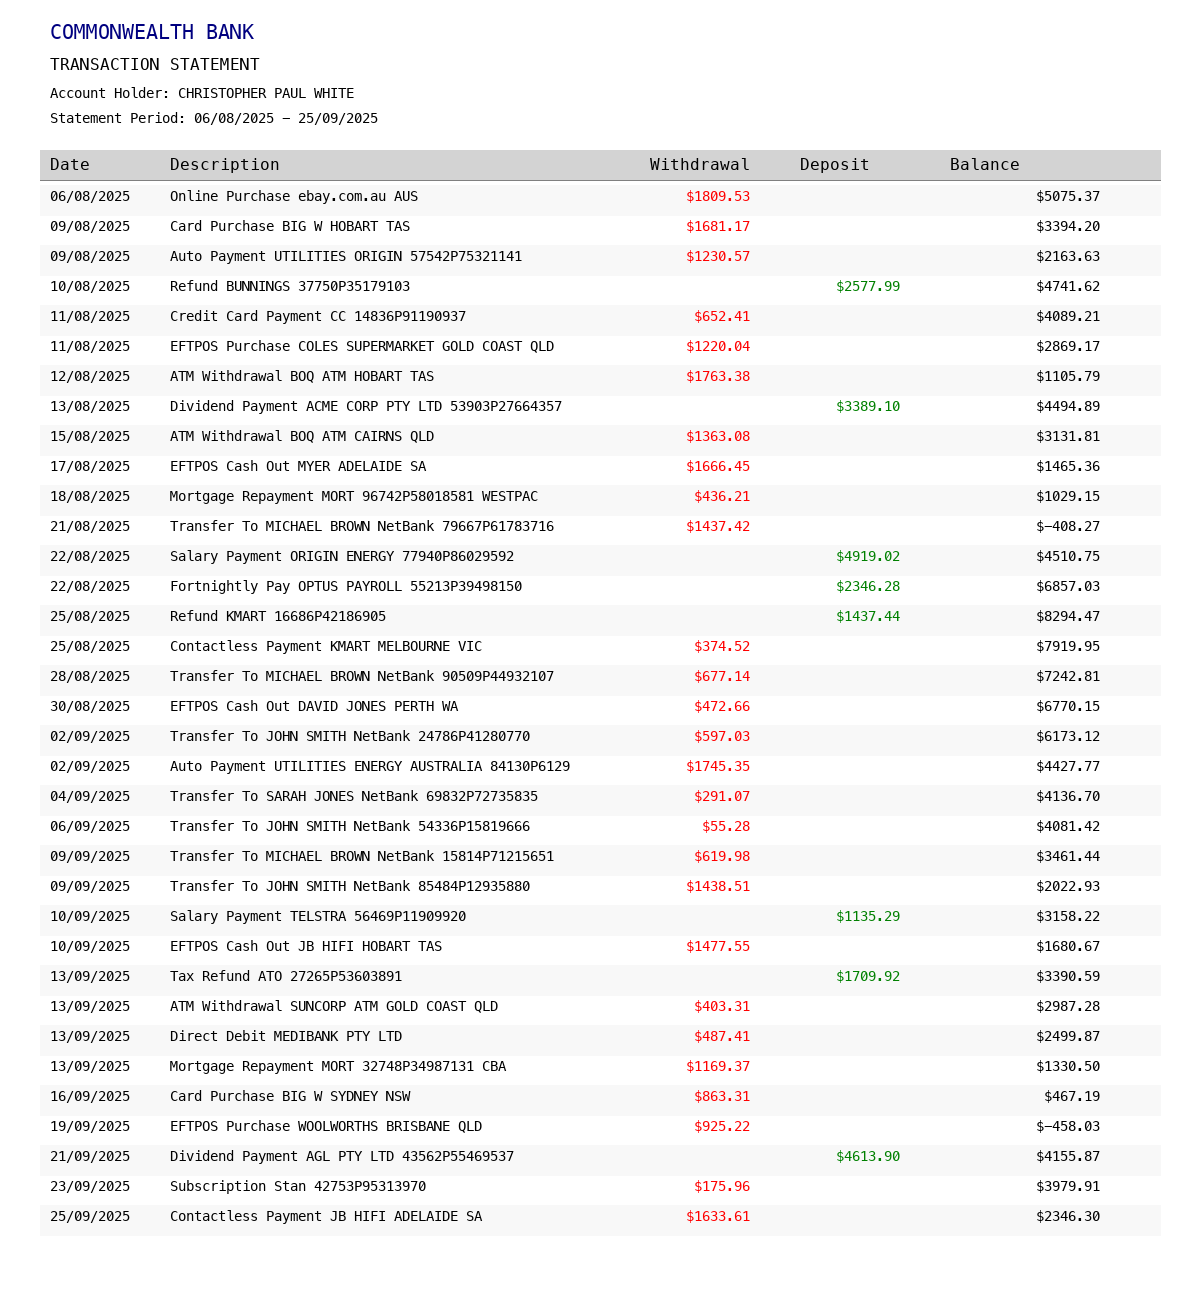

In [3]:
# Cell 5: Load bank statement image
# Update this path to your test image
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/minimal/image_003.png"
# imageName = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/minimal/image_009.png"
# imageName = "${HOME}/nfs_share/tod/LMM_POC/evaluation_data/bank/synthetic_chrono.png"
# imageName = str(Path.home() / "nfs_share/tod/LMM_POC/evaluation_data/bank/synthetic_chrono.png")
imageName = str(Path.home() / "nfs_share/tod/LMM_POC/evaluation_data/bank/synthetic_multiline.png")

print("📁 Loading image...")
image = Image.open(imageName)

# CRITICAL: Store as list for compatibility
images = [image]

print(f"✅ Image loaded: {image.size}")
print(f"✅ Images list created with {len(images)} image(s)")

# Display the loaded image for visual verification
print("🖼️  Bank statement image:")
display(image)

# Bank Statement Extraction Protocol (2-Turn Balance-Description)
- Turn 0: Identify actual table headers
- Turn 1: Extract using balance-description prompt
- Python: Parse, filter, and extract schema fields

In [4]:
# Cell 7: Turn 0 - Identify table headers (prompt)
# TURN 0: Identify Table Headers

prompt = """
Look at the transaction table in this bank statement image.

What are the exact column header names used in the transaction table?

List each column header exactly as it appears, in order from left to right.
Do not interpret or rename them - use the EXACT text from the image.
"""

# Create message structure for Llama
messageDataStructure = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {
                "type": "text",
                "text": prompt,
            },
        ],
    }
]

print("💬 TURN 0: Identifying actual table headers")
print("🤖 Generating response with Llama-3.2-Vision...")

💬 TURN 0: Identifying actual table headers
🤖 Generating response with Llama-3.2-Vision...


In [5]:
# Cell 8: Turn 0 - Execute and parse headers

textInput = processor.apply_chat_template(
    messageDataStructure, add_generation_prompt=True
)

inputs = processor(images=images, text=textInput, return_tensors="pt").to(model.device)

output = model.generate(
    **inputs,
    max_new_tokens=500,
    do_sample=False,
    temperature=None,
    top_p=None,
)

generate_ids = output[:, inputs['input_ids'].shape[1]:-1]
turn0_response = processor.decode(generate_ids[0], clean_up_tokenization_spaces=False)

# Free memory
del inputs, output, generate_ids
torch.cuda.empty_cache()

print("✅ Response generated successfully!")
print("\n" + "=" * 60)
print("TURN 0 - IDENTIFIED TABLE HEADERS:")
print("=" * 60)
print(turn0_response)
print("=" * 60)

# Parse the identified headers
header_lines = [line.strip() for line in turn0_response.split('\n') if line.strip()]
identified_headers = []

for line in header_lines:
    cleaned = line.lstrip('0123456789.-•* ').strip()
    cleaned = cleaned.replace('**', '').replace('__', '')
    if cleaned.endswith(':'):
        continue
    if len(cleaned) > 40:
        continue
    if cleaned and len(cleaned) > 2:
        identified_headers.append(cleaned)

print(f"\n📋 Parsed {len(identified_headers)} column headers:")
for i, header in enumerate(identified_headers, 1):
    print(f"  {i}. '{header}'")

# Store for subsequent turns
table_headers = identified_headers
print(f"\n✅ Stored table_headers: {table_headers}")

✅ Response generated successfully!

TURN 0 - IDENTIFIED TABLE HEADERS:
**Transaction Table Column Headers:**

*   **Date**
*   **Description**
*   **Withdrawal**
*   **Deposit**
*   **Balance**

📋 Parsed 5 column headers:
  1. 'Date'
  2. 'Description'
  3. 'Withdrawal'
  4. 'Deposit'
  5. 'Balance'

✅ Stored table_headers: ['Date', 'Description', 'Withdrawal', 'Deposit', 'Balance']


## Pattern Matching: Map Generic Concepts to Actual Headers

Different bank statements use different column names. Use pattern matching to identify:
- Which header represents **Date**
- Which header represents **Description/Details**  
- Which header represents **Debit/Withdrawal**
- Which header represents **Credit/Deposit**
- Which header represents **Balance** (CRITICAL for this approach!)

In [6]:
# Cell 9: Pattern Matching - Map headers to generic columns

DATE_PATTERNS = ['date', 'day', 'transaction date', 'trans date']
DESCRIPTION_PATTERNS = [
    'description', 'details', 'transaction details', 'trans details',
    'particulars', 'narrative', 'transaction', 'trans'
]
DEBIT_PATTERNS = ['debit', 'debits', 'withdrawal', 'withdrawals', 'paid', 'paid out', 'spent', 'dr']
CREDIT_PATTERNS = ['credit', 'credits', 'deposit', 'deposits', 'received', 'cr']
BALANCE_PATTERNS = ['balance', 'bal', 'running balance']
AMOUNT_PATTERNS = ['amount', 'amt', 'value', 'total']

def match_header(headers, patterns, fallback=None):
    """Match a header using pattern keywords."""
    headers_lower = [h.lower() for h in headers]
    
    # Try exact match first
    for pattern in patterns:
        for i, header_lower in enumerate(headers_lower):
            if pattern == header_lower:
                return headers[i]
    
    # Try substring match
    for pattern in patterns:
        if len(pattern) > 2:
            for i, header_lower in enumerate(headers_lower):
                if pattern in header_lower:
                    return headers[i]
    
    return fallback

# Perform pattern matching
date_col = match_header(table_headers, DATE_PATTERNS, fallback=table_headers[0] if table_headers else 'Date')
desc_col = match_header(table_headers, DESCRIPTION_PATTERNS, fallback=table_headers[1] if len(table_headers) > 1 else 'Description')
amount_col = match_header(table_headers, AMOUNT_PATTERNS, fallback=None)
debit_col = match_header(table_headers, DEBIT_PATTERNS, fallback=amount_col if amount_col else 'Debit')
credit_col = match_header(table_headers, CREDIT_PATTERNS, fallback=amount_col if amount_col else 'Credit')
balance_col = match_header(table_headers, BALANCE_PATTERNS, fallback=None)

print("=" * 60)
print("PATTERN MATCHING RESULTS:")
print("=" * 60)
print(f"📋 Extracted Headers: {table_headers}")
print(f"\n🔍 Mapped Columns:")
print(f"  Date        → '{date_col}'")
print(f"  Description → '{desc_col}'")
print(f"  Debit       → '{debit_col}'")
print(f"  Credit      → '{credit_col}'")
print(f"  Balance     → '{balance_col}'")

# CRITICAL: Check if Balance column exists
has_balance = balance_col is not None and balance_col in table_headers
print(f"\n🎯 Balance column detected: {'✅ YES' if has_balance else '❌ NO'}")

if not has_balance:
    print("⚠️  WARNING: No balance column found. This notebook requires a balance column.")
    print("   Consider using the 3-turn table extraction notebook instead.")

PATTERN MATCHING RESULTS:
📋 Extracted Headers: ['Date', 'Description', 'Withdrawal', 'Deposit', 'Balance']

🔍 Mapped Columns:
  Date        → 'Date'
  Description → 'Description'
  Debit       → 'Withdrawal'
  Credit      → 'Deposit'
  Balance     → 'Balance'

🎯 Balance column detected: ✅ YES


## Turn 1: Balance-Description Extraction

This is the key innovation - instead of extracting a markdown table, we ask the model to list all balances with their associated transaction details.

**Prompt Pattern:**
```
List all the balances in the {balance_col} column, including:
- Date from the Date Header of the balance
- {desc_col}
- {debit_col} Amount or "NOT_FOUND"
- {credit_col} Amount or "NOT_FOUND"
```

This produces hierarchical output that's easy to parse and works for both date formats!

In [7]:
# Cell 10: Turn 1 - Balance-Description Extraction Prompt

if has_balance:
#     extraction_prompt = f"""List all the balances in the {balance_col} column, including:
# - Date from the Date Header of the balance
# - {desc_col}
# - {debit_col} Amount or "NOT_FOUND"
# - {credit_col} Amount or "NOT_FOUND" """
    
    extraction_prompt = f"""List all the balances in the {balance_col} column, including:
- Date from the Date Header of the balance
- {desc_col}
- {debit_col} Amount or "NOT_FOUND"
- {credit_col} Amount or "NOT_FOUND"

Format each balance entry like this:
1. **[Date]**
   - {desc_col}: [description text]
   - {debit_col}: [amount or NOT_FOUND]
   - {credit_col}: [amount or NOT_FOUND]
   - {balance_col}: [balance amount]

CRITICAL RULES:
1. List EVERY balance entry in order from top to bottom
2. EVERY balance entry has a date, either on the same row, or above
3. Include the FULL description text, not abbreviated
4. If amount is in {debit_col} column, put it there and use NOT_FOUND for {credit_col}
5. If amount is in {credit_col} column, put it there and use NOT_FOUND for {debit_col}
6. Do NOT skip any transactions
"""
    
    print("📝 TURN 1: Balance-Description Extraction")
    print("=" * 60)
    print("Extraction Prompt:")
    print(extraction_prompt)
    print("=" * 60)
else:
    print("❌ Cannot proceed - no balance column detected.")
    extraction_prompt = None

📝 TURN 1: Balance-Description Extraction
Extraction Prompt:
List all the balances in the Balance column, including:
- Date from the Date Header of the balance
- Description
- Withdrawal Amount or "NOT_FOUND"
- Deposit Amount or "NOT_FOUND"

Format each balance entry like this:
1. **[Date]**
   - Description: [description text]
   - Withdrawal: [amount or NOT_FOUND]
   - Deposit: [amount or NOT_FOUND]
   - Balance: [balance amount]

CRITICAL RULES:
1. List EVERY balance entry in order from top to bottom
2. EVERY balance entry has a date, either on the same row, or above
3. Include the FULL description text, not abbreviated
4. If amount is in Withdrawal column, put it there and use NOT_FOUND for Deposit
5. If amount is in Deposit column, put it there and use NOT_FOUND for Withdrawal
6. Do NOT skip any transactions



In [8]:
# Cell 11: Turn 1 - Execute extraction (INDEPENDENT, fresh context)

if extraction_prompt:
    # CRITICAL: Create FRESH message structure (NOT appending to conversation history)
    messageDataStructure_turn1 = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": extraction_prompt}
            ]
        }
    ]
    
    print("🤖 Generating response with Llama-3.2-Vision...")
    
    textInput = processor.apply_chat_template(
        messageDataStructure_turn1, add_generation_prompt=True
    )
    
    inputs = processor(images=images, text=textInput, return_tensors="pt").to(model.device)
    
    output = model.generate(
        **inputs,
        max_new_tokens=4096,  # Increased for balance-description output
        do_sample=False,
        temperature=None,
        top_p=None,
    )
    
    generate_ids = output[:, inputs['input_ids'].shape[1]:-1]
    extraction_response = processor.decode(generate_ids[0], clean_up_tokenization_spaces=False)
    
    # Free memory
    del inputs, output, generate_ids
    torch.cuda.empty_cache()
    
    print("\n✅ Turn 1 extraction complete!")
    print(f"\n📊 Response length: {len(extraction_response)} characters")
    print("\n" + "=" * 60)
    print("TURN 1 - BALANCE-DESCRIPTION EXTRACTION:")
    print("=" * 60)
    print(extraction_response)
    print("=" * 60)
else:
    print("❌ Skipping extraction - no valid prompt.")
    extraction_response = None

🤖 Generating response with Llama-3.2-Vision...

✅ Turn 1 extraction complete!

📊 Response length: 5286 characters

TURN 1 - BALANCE-DESCRIPTION EXTRACTION:
**Balance Entries**

1. **06/08/2025**
   - Description: Online Purchase ebay.com.au AUS
   - Withdrawal: $1809.53
   - Deposit: NOT_FOUND
   - Balance: $5075.37

2. **09/08/2025**
   - Description: Card Purchase BIG W HOBART TAS
   - Withdrawal: $1681.17
   - Deposit: NOT_FOUND
   - Balance: $3394.20

3. **09/08/2025**
   - Description: Auto Payment UTILITIES ORIGIN 57542P75321141
   - Withdrawal: $1230.57
   - Deposit: NOT_FOUND
   - Balance: $2163.63

4. **10/08/2025**
   - Description: Refund BUNNINGS 37750P35179103
   - Withdrawal: $652.41
   - Deposit: NOT_FOUND
   - Balance: $4741.62

5. **11/08/2025**
   - Description: Credit Card Payment CC 14836P91190937
   - Withdrawal: $1220.04
   - Deposit: NOT_FOUND
   - Balance: $4089.21

6. **11/08/2025**
   - Description: EFTPOS Purchase COLES SUPERMARKET GOLD COAST QLD
   - Withdra

## Python Parsing: Balance-Description Response

Parse the hierarchical balance-description output into transaction rows.

Expected format:
```
1. **Thu 04 Sep 2025**
   - Description: Direct Debit DOMINO'S PTY LTD
   - Debit: $117.57
   - Balance: $8586.28 CR
```

In [9]:
# Cell 12: Parse balance-description response

def parse_balance_description_response(response_text, date_col, desc_col, debit_col, credit_col, balance_col):
    """Parse the hierarchical balance-description response into transaction rows.

    Handles multiple output formats:
    - InternVL3: "1. **Date:** 03/05/2025" with "**Field:** value"
    - Llama: "**03/05/2025**" with "* Field: value"
    - Standard: "1. **date**" with "- Field: value"
    """
    rows = []
    current_date = None
    current_transaction = {}

    lines = response_text.strip().split("\n")

    for line in lines:
        line = line.strip()
        if not line:
            continue

        # ============================================================
        # DATE DETECTION PATTERNS
        # ============================================================
        date_found = None

        # Pattern 1: InternVL3 format "1. **Date:** 03/05/2025" or "**Date:** 03/05/2025"
        date_field_match = re.match(r"^\d*\.?\s*\*?\*?Date:?\*?\*?\s*(.+)$", line, re.IGNORECASE)
        if date_field_match:
            date_found = date_field_match.group(1).strip().strip('*').strip()

        # Pattern 2: Bold date header "**03/05/2025**" (Llama style)
        if not date_found:
            bold_date_match = re.match(r"^\*\*(\d{1,2}/\d{1,2}/\d{4})\*\*$", line)
            if bold_date_match:
                date_found = bold_date_match.group(1)

        # Pattern 3: Numbered bold date "1. **Thu 04 Sep 2025**"
        if not date_found:
            date_match = re.match(r"^\d+\.\s*\*?\*?([A-Za-z]{3}\s+\d{1,2}\s+[A-Za-z]{3}\s+\d{4})\*?\*?", line)
            if date_match:
                date_found = date_match.group(1).strip()

        # Pattern 4: Numbered date without day "1. **04 Sep 2025**"
        if not date_found:
            date_match = re.match(r"^\d+\.\s*\*?\*?(\d{1,2}\s+[A-Za-z]{3}\s+\d{4})\*?\*?", line)
            if date_match:
                date_found = date_match.group(1).strip()

        # Pattern 5: Numbered DD/MM/YYYY "1. **03/05/2025**"
        if not date_found:
            date_match = re.match(r"^\d+\.\s*\*?\*?(\d{1,2}/\d{1,2}/\d{4})\*?\*?", line)
            if date_match:
                date_found = date_match.group(1).strip()

        if date_found:
            # Save previous transaction if exists
            if current_transaction and current_date:
                current_transaction[date_col] = current_date
                rows.append(current_transaction)
                current_transaction = {}
            current_date = date_found
            continue

        # ============================================================
        # FIELD DETECTION PATTERNS
        # ============================================================
        field_name = None
        field_value = None

        # Pattern 1: "**Description:** value" (InternVL3 style)
        bold_field_match = re.match(r"^\s*\*\*([^*:]+)(?:\s*Amount)?:?\*\*\s*(.+)$", line, re.IGNORECASE)
        if bold_field_match:
            field_name = bold_field_match.group(1).strip().lower()
            field_value = bold_field_match.group(2).strip()

        # Pattern 2: "* Description: value" (Llama style with asterisk bullet)
        if not field_name:
            asterisk_field_match = re.match(r"^\s*\*\s*([^:]+):\s*(.+)$", line)
            if asterisk_field_match:
                field_name = asterisk_field_match.group(1).strip().lower()
                field_value = asterisk_field_match.group(2).strip()

        # Pattern 3: "- Description: value" (standard style)
        if not field_name:
            dash_field_match = re.match(r"^\s*-\s*([^:]+):\s*(.+)$", line)
            if dash_field_match:
                field_name = dash_field_match.group(1).strip().lower()
                field_value = dash_field_match.group(2).strip()

        if field_name and field_value:
            # Normalize field names (remove "amount" suffix, handle variants)
            field_name = field_name.replace(" amount", "").strip()

            # Map to appropriate column
            if field_name in ["description", "transaction", "details", "particulars", desc_col.lower()]:
                # If we already have a description, this is a new transaction under same date
                if desc_col in current_transaction and current_transaction[desc_col]:
                    if current_date:
                        current_transaction[date_col] = current_date
                    rows.append(current_transaction)
                    current_transaction = {}
                current_transaction[desc_col] = field_value

            elif field_name in ["debit", "withdrawal", "withdrawwal", "dr", debit_col.lower()]:
                current_transaction[debit_col] = field_value

            elif field_name in ["credit", "deposit", "cr", credit_col.lower()]:
                current_transaction[credit_col] = field_value

            elif field_name == "balance":
                current_transaction[balance_col] = field_value

            elif field_name == "amount":
                # Generic amount - put in debit by default
                if debit_col not in current_transaction:
                    current_transaction[debit_col] = field_value

    # Don't forget the last transaction
    if current_transaction and current_date:
        current_transaction[date_col] = current_date
        rows.append(current_transaction)

    return rows


def parse_markdown_table(markdown_text):
    """Fallback: Parse markdown table into list of dictionaries."""
    lines = [line.strip() for line in markdown_text.strip().split('\n') if line.strip()]
    
    header_idx = None
    for i, line in enumerate(lines):
        if '|' in line:
            cleaned = line.replace('|', '').replace('-', '').replace(' ', '')
            if cleaned:
                header_idx = i
                break
    
    if header_idx is None:
        return []
    
    header_line = lines[header_idx]
    header_parts = [h.strip() for h in header_line.split('|')]
    if header_parts and header_parts[0] == '':
        header_parts = header_parts[1:]
    if header_parts and header_parts[-1] == '':
        header_parts = header_parts[:-1]
    headers = [h for h in header_parts if h]
    
    rows = []
    for line in lines[header_idx + 1:]:
        if '|' not in line:
            continue
        cleaned = line.replace('|', '').replace('-', '').replace(' ', '').replace(':', '')
        if not cleaned:
            continue
        value_parts = [v.strip() for v in line.split('|')]
        if value_parts and value_parts[0] == '':
            value_parts = value_parts[1:]
        if value_parts and value_parts[-1] == '':
            value_parts = value_parts[:-1]
        if len(value_parts) == len(headers):
            rows.append(dict(zip(headers, value_parts)))
    
    return rows


# Parse the extraction response
if extraction_response:
    # Try balance-description format first
    all_rows = parse_balance_description_response(
        extraction_response, date_col, desc_col, debit_col, credit_col, balance_col
    )
    
    # Fallback to markdown table if balance-description parsing failed
    if not all_rows and "|" in extraction_response:
        print("⚠️  Fallback: parsing as markdown table")
        all_rows = parse_markdown_table(extraction_response)
    
    print(f"\n📊 Parsed {len(all_rows)} total rows")
    
    # Display parsed rows
    print("\n" + "=" * 60)
    print("PARSED TRANSACTIONS:")
    print("=" * 60)
    for i, row in enumerate(all_rows[:10]):  # Show first 10
        print(f"\n{i+1}. {row}")
    if len(all_rows) > 10:
        print(f"\n... and {len(all_rows) - 10} more rows")
else:
    all_rows = []


📊 Parsed 35 total rows

PARSED TRANSACTIONS:

1. {'Description': 'Online Purchase ebay.com.au AUS', 'Withdrawal': '$1809.53', 'Deposit': 'NOT_FOUND', 'Balance': '$5075.37', 'Date': '06/08/2025'}

2. {'Description': 'Card Purchase BIG W HOBART TAS', 'Withdrawal': '$1681.17', 'Deposit': 'NOT_FOUND', 'Balance': '$3394.20', 'Date': '09/08/2025'}

3. {'Description': 'Auto Payment UTILITIES ORIGIN 57542P75321141', 'Withdrawal': '$1230.57', 'Deposit': 'NOT_FOUND', 'Balance': '$2163.63', 'Date': '09/08/2025'}

4. {'Description': 'Refund BUNNINGS 37750P35179103', 'Withdrawal': '$652.41', 'Deposit': 'NOT_FOUND', 'Balance': '$4741.62', 'Date': '10/08/2025'}

5. {'Description': 'Credit Card Payment CC 14836P91190937', 'Withdrawal': '$1220.04', 'Deposit': 'NOT_FOUND', 'Balance': '$4089.21', 'Date': '11/08/2025'}

6. {'Description': 'EFTPOS Purchase COLES SUPERMARKET GOLD COAST QLD', 'Withdrawal': '$1763.38', 'Deposit': 'NOT_FOUND', 'Balance': '$2869.17', 'Date': '11/08/2025'}

7. {'Description': '

## Filter for Debit Transactions

For tax purposes, we only want transactions where the taxpayer PAID money (debits/withdrawals).

In [10]:
# Cell: Balance-Based Debit/Credit Validation Function
# CRITICAL: Rows must be sorted by date for balance validation to work correctly
# BUT: Returns rows in ORIGINAL order to match ground truth for evaluation

from dateutil import parser as date_parser


def sort_rows_by_date(rows, date_col):
    """
    Sort rows by date in chronological order (oldest first).
    
    This is CRITICAL because LLM extraction often returns rows in scrambled order.
    Balance validation requires sequential date order to work correctly.
    
    Args:
        rows: List of dictionaries (parsed markdown table rows)
        date_col: Name of the Date column
    
    Returns:
        Tuple of (sorted_rows, original_indices, was_reordered) where:
        - sorted_rows: Rows sorted by date
        - original_indices: List mapping sorted position -> original position
        - was_reordered: True if sorting changed the order
    """
    if not rows or date_col not in rows[0]:
        print(f"⚠️  Date column '{date_col}' not found - cannot sort")
        return rows, list(range(len(rows))), False
    
    def parse_date(date_str):
        """Parse date string to datetime for sorting."""
        if not date_str or not date_str.strip():
            return None
        try:
            # Use dayfirst=True for Australian date format (DD/MM/YYYY)
            return date_parser.parse(date_str.strip(), dayfirst=True)
        except (ValueError, TypeError):
            return None
    
    # Create list of (parsed_date, original_index, row) for sorting
    dated_rows = []
    for i, row in enumerate(rows):
        parsed = parse_date(row.get(date_col, ""))
        dated_rows.append((parsed, i, row))
    
    # Check if any dates failed to parse
    failed_parses = sum(1 for d, _, _ in dated_rows if d is None)
    if failed_parses > len(rows) * 0.5:
        print(f"⚠️  Too many date parse failures ({failed_parses}/{len(rows)}) - cannot sort reliably")
        return rows, list(range(len(rows))), False
    
    # Sort by date (None dates go to end)
    sorted_dated = sorted(dated_rows, key=lambda x: (x[0] is None, x[0]))
    
    # Extract sorted rows and original indices
    sorted_rows = [row for _, _, row in sorted_dated]
    original_indices = [orig_idx for _, orig_idx, _ in sorted_dated]
    
    # Check if order changed
    was_reordered = original_indices != list(range(len(rows)))
    
    return sorted_rows, original_indices, was_reordered


def detect_document_order(rows, balance_col):
    """
    Detect if document is in chronological or reverse chronological order.
    
    Logic: If balances generally INCREASE going down the table, the document
    is in reverse chronological order (newest first, oldest last).
    
    Returns:
        str: "chronological" or "reverse_chronological"
    """
    def parse_amount(value):
        if not value or value.strip() == "":
            return 0.0
        cleaned = value.replace("$", "").replace(",", "").replace("CR", "").replace("DR", "").strip()
        try:
            return float(cleaned)
        except ValueError:
            return 0.0
    
    if len(rows) < 3:
        return "chronological"  # Default assumption
    
    # Sample multiple balance transitions to determine trend
    increases = 0
    decreases = 0
    
    for i in range(1, min(len(rows), 10)):  # Check first 10 rows
        prev_balance = parse_amount(rows[i-1].get(balance_col, "0"))
        curr_balance = parse_amount(rows[i].get(balance_col, "0"))
        
        if curr_balance > prev_balance + 0.01:
            increases += 1
        elif curr_balance < prev_balance - 0.01:
            decreases += 1
    
    # If balances mostly increase going down → reverse chronological
    if increases > decreases:
        return "reverse_chronological"
    else:
        return "chronological"


def validate_and_correct_alignment(rows, balance_col, debit_col, credit_col, desc_col, date_col="Date"):
    """
    Use balance changes to validate and correct debit/credit alignment.
    
    CRITICAL: This function SORTS rows by date for validation, but RETURNS
    rows in their ORIGINAL order to preserve ground truth alignment for evaluation.
    
    Process:
    1. Sort rows by date (for accurate balance validation)
    2. Validate and correct using sorted order
    3. Map corrections back to original row positions
    4. Return rows in ORIGINAL order with corrections applied
    
    Args:
        rows: List of dictionaries (parsed markdown table rows)
        balance_col: Name of the Balance column
        debit_col: Name of the Debit column
        credit_col: Name of the Credit column
        desc_col: Name of the Description column (to detect opening/closing balance)
        date_col: Name of the Date column (for sorting)
    
    Returns:
        List of corrected row dictionaries (in ORIGINAL order, not sorted)
    """
    
    def parse_amount(value):
        """Extract numeric value from formatted currency string."""
        if not value or value.strip() == "":
            return 0.0
        # Remove currency symbols, commas, CR/DR markers
        cleaned = value.replace("$", "").replace(",", "").replace("CR", "").replace("DR", "").strip()
        try:
            return float(cleaned)
        except ValueError:
            return 0.0
    
    def is_balance_row(row, desc_col):
        """Check if this row is an opening/closing balance row (not a transaction)."""
        desc = row.get(desc_col, "").upper()
        return "OPENING BALANCE" in desc or "CLOSING BALANCE" in desc
    
    # Check if Balance column exists
    if not rows or balance_col not in rows[0]:
        print(f"⚠️  Balance column '{balance_col}' not found - skipping validation")
        return rows
    
    # CRITICAL: Sort rows by date FIRST for accurate validation
    print("📅 Sorting rows by date for accurate balance validation...")
    sorted_rows, original_indices, was_reordered = sort_rows_by_date(rows, date_col)
    
    if was_reordered:
        print("✅ Rows were reordered by date (LLM extraction was not in date order)")
    else:
        print("✅ Rows were already in date order")
    
    # After sorting, detect document order on the sorted rows
    doc_order = detect_document_order(sorted_rows, balance_col)
    print(f"📊 Document order detected (after sort): {doc_order.upper()}")
    
    if doc_order == "reverse_chronological":
        print("💡 Reverse chronological detected even after date sorting")
        print("💡 Validation logic inverted: balance increase → DEBIT, balance decrease → CREDIT")
    
    # Create a copy of original rows for correction (preserves original order)
    corrected_rows = [row.copy() for row in rows]
    corrections_made = 0
    
    # Build reverse mapping: original_index -> sorted_index
    sorted_to_original = {sorted_idx: orig_idx for sorted_idx, orig_idx in enumerate(original_indices)}
    
    # Track which sorted indices are balance rows (to skip)
    balance_row_indices = set()
    for sorted_idx, row in enumerate(sorted_rows):
        if is_balance_row(row, desc_col):
            balance_row_indices.add(sorted_idx)
    
    # Validate using SORTED order, apply corrections to ORIGINAL positions
    start_idx = 0
    
    # Check if row 0 (in sorted order) is an opening balance row
    if sorted_rows and is_balance_row(sorted_rows[0], desc_col):
        print(f"✅ Sorted row 0: Opening/closing balance detected - skipping (not a transaction)")
        start_idx = 1
    elif sorted_rows:
        print(f"✅ Sorted row 0: First transaction included without validation (no previous balance to compare)")
        start_idx = 1
    
    # Validate remaining rows using sorted order
    for sorted_idx in range(start_idx, len(sorted_rows)):
        current_row = sorted_rows[sorted_idx]
        original_idx = original_indices[sorted_idx]
        
        # Skip balance rows
        if sorted_idx in balance_row_indices:
            print(f"⚠️  Sorted row {sorted_idx}: Opening/closing balance row detected - skipping")
            continue
        
        # Find previous non-balance row in sorted order
        prev_sorted_idx = sorted_idx - 1
        while prev_sorted_idx >= 0 and prev_sorted_idx in balance_row_indices:
            prev_sorted_idx -= 1
        
        if prev_sorted_idx < 0:
            print(f"✅ Sorted row {sorted_idx}: First transaction after balance row - included without validation")
            continue
        
        # Parse balances from sorted rows
        prev_balance = parse_amount(sorted_rows[prev_sorted_idx].get(balance_col, "0"))
        curr_balance = parse_amount(current_row.get(balance_col, "0"))
        
        # Calculate balance change
        balance_change = curr_balance - prev_balance
        
        # Parse current debit/credit values
        debit_value = parse_amount(current_row.get(debit_col, ""))
        credit_value = parse_amount(current_row.get(credit_col, ""))
        
        # Determine if correction needed and apply to ORIGINAL position
        correction_needed = False
        swap_to_debit = False  # True = move from Credit to Debit, False = move from Debit to Credit
        
        if doc_order == "reverse_chronological":
            if balance_change > 0.01 and credit_value > 0 and debit_value == 0:
                correction_needed = True
                swap_to_debit = True
                print(f"⚠️  Row {original_idx} (sorted {sorted_idx}): Balance increased by ${balance_change:.2f} → moving ${credit_value:.2f} Credit → Debit")
            elif balance_change < -0.01 and debit_value > 0 and credit_value == 0:
                correction_needed = True
                swap_to_debit = False
                print(f"⚠️  Row {original_idx} (sorted {sorted_idx}): Balance decreased by ${abs(balance_change):.2f} → moving ${debit_value:.2f} Debit → Credit")
        else:
            if balance_change > 0.01 and debit_value > 0 and credit_value == 0:
                correction_needed = True
                swap_to_debit = False
                print(f"⚠️  Row {original_idx} (sorted {sorted_idx}): Balance increased by ${balance_change:.2f} → moving ${debit_value:.2f} Debit → Credit")
            elif balance_change < -0.01 and credit_value > 0 and debit_value == 0:
                correction_needed = True
                swap_to_debit = True
                print(f"⚠️  Row {original_idx} (sorted {sorted_idx}): Balance decreased by ${abs(balance_change):.2f} → moving ${credit_value:.2f} Credit → Debit")
        
        # Apply correction to the ORIGINAL position
        if correction_needed:
            if swap_to_debit:
                corrected_rows[original_idx][debit_col] = corrected_rows[original_idx][credit_col]
                corrected_rows[original_idx][credit_col] = ""
            else:
                corrected_rows[original_idx][credit_col] = corrected_rows[original_idx][debit_col]
                corrected_rows[original_idx][debit_col] = ""
            corrections_made += 1
    
    print(f"\n✅ Balance validation complete: {corrections_made} corrections made")
    print(f"✅ Total rows processed: {len(rows)} (returned in ORIGINAL order)")
    return corrected_rows

print("✅ Balance validation function defined")
print("💡 CRITICAL: Rows are SORTED BY DATE for validation accuracy")
print("💡 CRITICAL: Rows are RETURNED IN ORIGINAL ORDER for ground truth evaluation")
print("💡 Opening/closing balance rows are automatically detected and skipped")

✅ Balance validation function defined
💡 CRITICAL: Rows are SORTED BY DATE for validation accuracy
💡 CRITICAL: Rows are RETURNED IN ORIGINAL ORDER for ground truth evaluation
💡 Opening/closing balance rows are automatically detected and skipped


## Extract Schema Fields

Convert parsed debit transactions to universal.yaml schema format:
- `TRANSACTION_DATES`: Pipe-delimited dates
- `LINE_ITEM_DESCRIPTIONS`: Pipe-delimited descriptions
- `TRANSACTION_AMOUNTS_PAID`: Pipe-delimited amounts

In [11]:
# Cell 14: Extract schema fields

from dateutil import parser as date_parser


def _compute_date_range(dates: list[str]) -> str:
    """
    Compute statement date range ensuring chronological order (oldest - newest).
    
    Bank statements may be in reverse chronological order (newest first),
    so we parse and sort dates to ensure correct order.
    
    Args:
        dates: List of date strings from transactions
        
    Returns:
        Date range string in format "oldest_date - newest_date"
    """
    if not dates:
        return "NOT_FOUND"
    
    # Parse dates with error handling
    parsed_dates = []
    for date_str in dates:
        if not date_str or not date_str.strip():
            continue
        try:
            # Try parsing with dayfirst=True for Australian format
            parsed = date_parser.parse(date_str.strip(), dayfirst=True)
            parsed_dates.append((parsed, date_str.strip()))
        except (ValueError, TypeError):
            # If parsing fails, skip this date
            continue
    
    if not parsed_dates:
        # Fallback to original order if parsing failed
        return f"{dates[0]} - {dates[-1]}" if len(dates) >= 2 else dates[0]
    
    # Sort by parsed date (chronological order)
    parsed_dates.sort(key=lambda x: x[0])
    
    # Return oldest - newest (using original string format)
    oldest = parsed_dates[0][1]
    newest = parsed_dates[-1][1]
    
    return f"{oldest} - {newest}"


def extract_schema_fields(debit_rows, date_col, desc_col, debit_col, all_rows=None):
    """Extract fields in universal.yaml schema format."""
    if not debit_rows:
        return {
            "DOCUMENT_TYPE": "BANK_STATEMENT",
            "STATEMENT_DATE_RANGE": "NOT_FOUND",
            "TRANSACTION_DATES": "NOT_FOUND",
            "LINE_ITEM_DESCRIPTIONS": "NOT_FOUND",
            "TRANSACTION_AMOUNTS_PAID": "NOT_FOUND",
        }
    
    # Extract debit transaction fields
    debit_dates = []
    descriptions = []
    amounts = []
    
    for row in debit_rows:
        date = row.get(date_col, "").strip()
        desc = row.get(desc_col, "").strip()
        amount = row.get(debit_col, "").strip()
        
        if date:
            debit_dates.append(date)
        if desc:
            descriptions.append(desc)
        if amount:
            amounts.append(amount)
    
    # Calculate date range from ALL transactions (not just debits)
    # Use _compute_date_range to ensure chronological order (oldest - newest)
    rows_for_range = all_rows if all_rows is not None else debit_rows
    all_dates = [row.get(date_col, "").strip() for row in rows_for_range]
    all_dates = [d for d in all_dates if d]
    date_range = _compute_date_range(all_dates)
    
    return {
        "DOCUMENT_TYPE": "BANK_STATEMENT",
        "STATEMENT_DATE_RANGE": date_range,
        "TRANSACTION_DATES": " | ".join(debit_dates) if debit_dates else "NOT_FOUND",
        "LINE_ITEM_DESCRIPTIONS": " | ".join(descriptions) if descriptions else "NOT_FOUND",
        "TRANSACTION_AMOUNTS_PAID": " | ".join(amounts) if amounts else "NOT_FOUND",
    }


# Extract schema fields
schema_fields = extract_schema_fields(debit_rows, date_col, desc_col, debit_col, all_rows=all_rows)

print("\n" + "=" * 60)
print("EXTRACTED SCHEMA FIELDS:")
print("=" * 60)
for field, value in schema_fields.items():
    # Truncate long values for display
    display_value = str(value)[:100] + "..." if len(str(value)) > 100 else str(value)
    print(f"\n{field}:")
    print(f"  {display_value}")

NameError: name 'debit_rows' is not defined

In [ ]:
# Cell 15: Load Ground Truth and Evaluate (using batch_v2 metrics)

import pandas as pd
from pathlib import Path
from dateutil import parser as date_parser

# Import evaluation metrics from common module (same as batch_v2 scripts)
from common.evaluation_metrics import (
    calculate_field_accuracy_f1,
    calculate_field_accuracy_f1_position_agnostic,
    calculate_field_accuracy_kieval,
    calculate_correlation_aware_f1,
    load_ground_truth,
)

# Bank statement fields to evaluate (same as batch_v2)
BANK_STATEMENT_FIELDS = [
    "DOCUMENT_TYPE",
    "STATEMENT_DATE_RANGE",
    "TRANSACTION_DATES",
    "LINE_ITEM_DESCRIPTIONS",
    "TRANSACTION_AMOUNTS_PAID",
]

# Ground truth configuration
GROUND_TRUTH_PATH = "/home/jovyan/nfs_share/tod/LMM_POC/evaluation_data/bank/ground_truth_bank.csv"

# Evaluation method: "order_aware_f1", "position_agnostic_f1", "kieval", or "correlation"
EVALUATION_METHOD = "order_aware_f1"

# ============================================================================
# SEMANTIC NORMALIZATION (same as batch_v2)
# ============================================================================
def normalize_date(date_str):
    """Normalize date string to canonical format YYYY-MM-DD for semantic comparison."""
    if not date_str or pd.isna(date_str):
        return ""
    date_str = str(date_str).strip()
    if not date_str:
        return ""
    try:
        parsed = date_parser.parse(date_str, dayfirst=True)
        return parsed.strftime("%Y-%m-%d")
    except (ValueError, TypeError):
        return date_str


def normalize_amount(amount_str):
    """Normalize amount string for semantic comparison."""
    if not amount_str or pd.isna(amount_str):
        return ""
    amount_str = str(amount_str).strip()
    if not amount_str:
        return ""
    # Remove currency symbols and whitespace
    cleaned = re.sub(r"[$£€¥₹\s]", "", amount_str)
    cleaned = cleaned.replace(",", "")
    try:
        value = float(cleaned)
        value = abs(value)  # Ignore sign for matching
        return f"{value:.2f}".rstrip("0").rstrip(".")
    except ValueError:
        return cleaned


def normalize_pipe_delimited(value, normalizer_fn):
    """Apply normalizer function to each item in a pipe-delimited string."""
    if not value or pd.isna(value):
        return ""
    value = str(value).strip()
    if not value:
        return ""
    items = [item.strip() for item in value.split("|")]
    normalized = [normalizer_fn(item) for item in items]
    return " | ".join(normalized)


def normalize_field_for_comparison(field_name, value):
    """Normalize a field value based on its type for semantic comparison."""
    if not value or pd.isna(value):
        return ""
    value = str(value).strip()
    if field_name == "TRANSACTION_DATES":
        return normalize_pipe_delimited(value, normalize_date)
    elif field_name == "TRANSACTION_AMOUNTS_PAID":
        return normalize_pipe_delimited(value, normalize_amount)
    elif field_name == "STATEMENT_DATE_RANGE":
        if " - " in value:
            parts = value.split(" - ")
            if len(parts) == 2:
                start = normalize_date(parts[0].strip())
                end = normalize_date(parts[1].strip())
                return f"{start} - {end}"
        return value
    else:
        return value


# ============================================================================
# EVALUATION FUNCTIONS (same as batch_v2)
# ============================================================================
def evaluate_field(extracted_value, gt_value, field_name, method):
    """Route to appropriate evaluation function."""
    if method == "order_aware_f1":
        return calculate_field_accuracy_f1(extracted_value, gt_value, field_name)
    elif method == "position_agnostic_f1":
        return calculate_field_accuracy_f1_position_agnostic(extracted_value, gt_value, field_name)
    elif method == "kieval":
        return calculate_field_accuracy_kieval(extracted_value, gt_value, field_name)
    elif method == "correlation":
        return None
    else:
        raise ValueError(f"Unknown evaluation method: {method}")


def evaluate_extraction(schema_fields, image_name, ground_truth_map, method):
    """Evaluate extracted schema fields against ground truth."""
    gt_data = ground_truth_map.get(image_name, {})
    
    if not gt_data:
        return {"error": "No ground truth found", "image_name": image_name}
    
    if method == "correlation":
        normalized_extracted = {
            field: normalize_field_for_comparison(field, schema_fields.get(field, ""))
            for field in BANK_STATEMENT_FIELDS
        }
        normalized_gt = {
            field: normalize_field_for_comparison(field, gt_data.get(field, ""))
            for field in BANK_STATEMENT_FIELDS
        }
        result = calculate_correlation_aware_f1(
            extracted_data=normalized_extracted,
            ground_truth_data=normalized_gt,
            document_type="bank_statement",
            debug=False,
        )
        return {
            "image_name": image_name,
            "method": method,
            "overall_accuracy": result.get("combined_f1", 0.0),
            "standard_f1": result.get("standard_f1", 0.0),
            "alignment_score": result.get("alignment_score", 0.0),
            "field_scores": result.get("field_f1_scores", {}),
        }
    
    field_scores = {}
    total_f1 = 0.0
    
    for field in BANK_STATEMENT_FIELDS:
        extracted_value = schema_fields.get(field, "NOT_FOUND")
        gt_value = gt_data.get(field, "NOT_FOUND")
        
        if pd.isna(gt_value):
            gt_value = "NOT_FOUND"
        
        normalized_extracted = normalize_field_for_comparison(field, extracted_value)
        normalized_gt = normalize_field_for_comparison(field, gt_value)
        
        result = evaluate_field(normalized_extracted, normalized_gt, field, method)
        
        if result:
            field_scores[field] = {
                "f1_score": result.get("f1_score", 0.0),
                "precision": result.get("precision", 0.0),
                "recall": result.get("recall", 0.0),
                "extracted": str(extracted_value)[:100],
                "ground_truth": str(gt_value)[:100],
            }
            total_f1 += result.get("f1_score", 0.0)
    
    overall_accuracy = total_f1 / len(BANK_STATEMENT_FIELDS) if BANK_STATEMENT_FIELDS else 0.0
    
    return {
        "image_name": image_name,
        "method": method,
        "overall_accuracy": overall_accuracy,
        "field_scores": field_scores,
    }


def display_field_comparison(schema_fields, ground_truth_map, image_name, eval_result):
    """Display stacked comparison of extracted vs ground truth fields."""
    gt_data = ground_truth_map.get(image_name, {})
    field_scores = eval_result.get("field_scores", {})
    
    print("\n" + "=" * 90)
    print(f"📊 FIELD COMPARISON ({EVALUATION_METHOD}) - {image_name}")
    print("=" * 90)
    
    print(f"\n{'Status':<8} {'Field':<30} {'F1':>8} {'Prec':>8} {'Recall':>8}")
    print("-" * 90)
    
    for field in BANK_STATEMENT_FIELDS:
        extracted_val = schema_fields.get(field, "NOT_FOUND")
        ground_val = gt_data.get(field, "NOT_FOUND")
        
        if pd.isna(ground_val):
            ground_val = "NOT_FOUND"
        
        if isinstance(field_scores.get(field), dict):
            f1_score = field_scores[field].get("f1_score", 0.0)
            precision = field_scores[field].get("precision", 0.0)
            recall = field_scores[field].get("recall", 0.0)
        else:
            f1_score = field_scores.get(field, 0.0)
            precision = 0.0
            recall = 0.0
        
        if f1_score == 1.0:
            status = "✅ OK"
        elif f1_score >= 0.5:
            status = "⚠️ PART"
        else:
            status = "❌ FAIL"
        
        print(f"{status:<8} {field:<30} {f1_score:>7.1%} {precision:>7.1%} {recall:>7.1%}")
    
    print("-" * 90)
    
    # Show detailed values
    print("\n📋 DETAILED VALUES:")
    print("-" * 90)
    for field in BANK_STATEMENT_FIELDS:
        extracted_val = schema_fields.get(field, "NOT_FOUND")
        gt_val = gt_data.get(field, "NOT_FOUND")
        if pd.isna(gt_val):
            gt_val = "NOT_FOUND"
        
        print(f"\n{field}:")
        print(f"  Extracted:    {str(extracted_val)[:80]}{'...' if len(str(extracted_val)) > 80 else ''}")
        print(f"  Ground Truth: {str(gt_val)[:80]}{'...' if len(str(gt_val)) > 80 else ''}")


# ============================================================================
# RUN EVALUATION
# ============================================================================
print("📁 Loading ground truth...")
ground_truth_map = load_ground_truth(GROUND_TRUTH_PATH, verbose=True)

# Get image filename for lookup
image_filename = Path(imageName).name
print(f"\n🔍 Looking up ground truth for: {image_filename}")

# Add DOCUMENT_TYPE to schema_fields if not present
if "DOCUMENT_TYPE" not in schema_fields:
    schema_fields["DOCUMENT_TYPE"] = "BANK_STATEMENT"

# Check if ground truth exists for this image
if image_filename in ground_truth_map:
    print(f"✅ Ground truth found!")
    
    # Evaluate using batch_v2 metrics
    eval_result = evaluate_extraction(schema_fields, image_filename, ground_truth_map, EVALUATION_METHOD)
    
    # Display comparison
    display_field_comparison(schema_fields, ground_truth_map, image_filename, eval_result)
    
    overall_f1 = eval_result.get("overall_accuracy", 0.0)
    
    print("\n" + "=" * 90)
    print(f"📊 OVERALL F1 SCORE ({EVALUATION_METHOD}): {overall_f1:.1%}")
    print("=" * 90)
else:
    print(f"⚠️  No ground truth found for: {image_filename}")
    print(f"   Available images: {list(ground_truth_map.keys())[:5]}...")
    overall_f1 = None

In [ ]:
# Cell 16: Summary

print("\n" + "=" * 60)
print("📊 EXTRACTION SUMMARY")
print("=" * 60)
print(f"\n🔧 Method: 2-Turn Balance-Description")
print(f"📋 Headers detected: {len(table_headers)}")
print(f"💰 Balance column: {balance_col}")
print(f"📝 Total transactions parsed: {len(all_rows)}")
print(f"💸 Debit transactions: {len(debit_rows)}")
if 'overall_f1' in dir():
    print(f"📊 Overall F1 Score: {overall_f1:.1%}")
print(f"\n✅ Pipeline complete!")